In [7]:
# import lib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tqdm
# from tqdm.auto import trange, tqdm
import os

# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# to get CFIAR10 dataset
from torchvision import transforms
import torchvision
import torchvision.transforms as transforms

# to import pretrained models
from transformers import AutoImageProcessor, MobileNetV1Model
import timm

# import sklearn
from sklearn.model_selection import train_test_split
from PIL import Image


# set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
from get_layers import get_encoder_layers, get_decoder_layers

---
## Unet architecture

In [9]:
from model import UnetWithoutAT
from utils import visualize_tensor_images

unet = UnetWithoutAT()

unet.image_stem_layer

MobileNetV1ConvLayer(
  (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (normalization): BatchNorm2d(32, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True)
  (activation): ReLU6()
)

In [10]:
# random input
x = torch.randn(1, 3, 224, 224)

# forward pass
y = unet(x)

# print output shape
print(y.shape)

torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


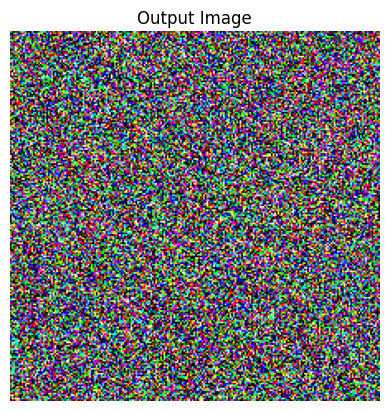

In [11]:
visualize_tensor_images(y[0], title="Output Image")

In [12]:
# now load the model
from utils import load_img_to_tensor, visualize_tensor_images
# load images 
input_tensor = load_img_to_tensor("../test/input/")

# print("Input tensor shape: ", input_tensor)

<class 'torch.Tensor'>
Input tensor shape: torch.Size([7, 3, 3705, 2405])


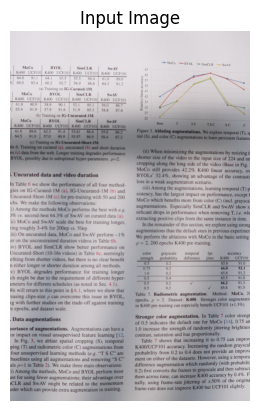

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 152 but got size 151 for tensor number 1 in the list.

In [14]:
# Print input tensor shape
print(type(input_tensor))
print("Input tensor shape:", input_tensor.shape)

# Visualize the first input image
visualize_tensor_images(input_tensor[0], title="Input Image")

# Pass input tensor through the UNet model
out_img = unet(input_tensor[0].reshape(1, 3, input_tensor.shape[2], input_tensor.shape[3]))

# Print output tensor shape
print("Output tensor shape:", out_img.shape)
``
# Visualize the output image
visualize_tensor_images(out_img[0], title="Output Image")

In [ ]:
# def visualize_tensor_images(tensor, title="Tensor", cmap=None):
# 	"""
# 	Visualizes a tensor as an image. shape = (3, H, W)
# 	"""
# 	tensor_np = tensor.detach().cpu().numpy()  # Convert tensor to numpy array
# 	plt.imshow(np.transpose(tensor_np, (1, 2, 0)), cmap=cmap)  # Transpose dimensions for imshow
# 	plt.title(title)
# 	plt.axis("off")
# 	plt.show()

In [ ]:
# # Load an image with path
# image_path = "..\\test\\input\\IMG_0106.png"

# # Load image
# image = Image.open(image_path)

# # Show original image
# plt.imshow(image)
# plt.title("Original Image")
# plt.axis("off")
# plt.show()

# # Preprocess image
# preprocessed_image = image_processor(image)['pixel_values'][0]

# # Transpose the NumPy array
# # preprocessed_image = preprocessed_image.transpose((1, 2, 0))

# print("Preprocessed image shape: ", preprocessed_image.shape)

# # Show preprocessed image
# plt.imshow(preprocessed_image.transpose((1, 2, 0)))
# plt.title("Preprocessed Image")
# plt.axis("off")
# plt.show()

In [ ]:
# class Unet(nn.Module):
# 	def __init__(self):
# 		'''
# 			Unet model
# 		'''
# 		super(Unet, self).__init__()
# 		# get encoder layers
# 		encoder_blocks, image_stem_layer, image_processor = get_encoder_layers()
# 		# get decoder layers
# 		decoder_blocks = get_decoder_layers()
		
# 		# print(len(encoder_blocks))
# 		# print(len(decoder_blocks))
		
# 		self.en1 = encoder_blocks[0]
# 		self.en2 = encoder_blocks[1]
# 		self.en3 = encoder_blocks[2]
# 		self.en4 = encoder_blocks[3]
# 		self.en5 = encoder_blocks[4]
		
# 		self.de1 = decoder_blocks[0]
# 		self.de2 = decoder_blocks[1]
# 		self.de3 = decoder_blocks[2]
# 		self.de4 = decoder_blocks[3]
# 		self.de5 = decoder_blocks[4]
		
# 		self.encoder_blocks = [
# 			self.en1,
# 			self.en2,
# 			self.en3,
# 			self.en4,
# 			self.en5
# 		]
		
# 		self.decoder_blocks = [
# 			self.de1,
# 			self.de2,
# 			self.de3,	
# 			self.de4,
# 			self.de5
# 		]
  
# 		self.image_processor = image_processor
		
# 		self.image_stem_layer = image_stem_layer
# 		self.out_image_stem_layer = nn.Sequential(
# 			nn.ConvTranspose2d(32,3, kernel_size=3, stride=2, bias=False),
# 			nn.BatchNorm2d(3, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True),
# 			nn.ReLU()
# 		)
		
# 	def forward(self, x, process_image = False):
# 		'''
# 			Forward pass
# 			x: input image (ideally should be of shape (batch_size, 3, 224, 224))
# 			process_image: whether to process image or not to the appropriate size
# 		'''
# 		# asset x is a tensor
# 		assert isinstance(x, torch.Tensor), "Input should be a tensor"
# 		if process_image:
# 			new_x = []
# 			for img in x:
# 				img = self.image_processor(img)['pixel_values'][0]
# 				new_x.append(img)
# 			x = torch.stack(new_x)
# 			x = x.permute(0, 3, 1, 2)
			
# 		# assetion to check if the image is of the right size
# 		assert x.shape[2] == 224 and x.shape[3] == 224, "Image size should be 224x224"
		
# 		x = self.image_stem_layer(x)
# 		print("Image stem layer output shape: ", x.shape)
		
# 		enc_outputs = []
# 		# run on each encoder block
# 		for indx, enc_block in enumerate(self.encoder_blocks):
# 			x = enc_block(x)
# 			enc_outputs.append(x)
# 			print(f"Encoder block {indx} | output shape: {x.shape}")
			
# 		# last encoder block to dec 
# 		# print input and output shapes
# 		# print("\nLast encoder block output shape: ", x.shape)
# 		# print()
		
# 		for indx, dec_block in enumerate(self.decoder_blocks):
# 			if indx == 0:
# 				x = dec_block(x)
# 				print(f"Decoder block {indx} | output shape: {x.shape}")
# 			else:
# 				x = dec_block(torch.cat([x, enc_outputs[len(self.decoder_blocks) - indx - 1]], dim=1))
# 				print(f"Decoder block {indx} | output shape: {x.shape}")
		
# 		return self.out_image_stem_layer(x)